In [ ]:
from CellClass import MCImage, imread
from CellClass.Segment import Segmentation
from CellClass.process_masks import get_cell_patches
from CellClass.Preprocessing import illumination, apply_clahe
import matplotlib.pyplot as plt

DC = Segmentation("deepcell")
CP = Segmentation("cellpose")

In [ ]:
%matplotlib inline
import numpy as np
img = imread("/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/processed/S4_461.tif")
MCIm = MCImage(img, scheme="BGR")
MCIm.normalize()

MCIm.B = apply_clahe(MCIm.B)

_, res, o_dc = DC(MCIm.B, return_outline=True, image_mpp=.4, MCIm=MCIm)
_, res, o_cp = CP(MCIm.B, return_outline=True, MCIm=MCIm)

plt.rcParams['figure.figsize'] = 20,20

plt.imshow(o_dc)
plt.show()
plt.imshow(o_cp)
plt.show()

In [ ]:
from tqdm import tqdm
from CellClass import Analyse as an

import os

base = "/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/results/patches"
files = [os.path.join(base, x) for x in os.listdir(base) if "S29" in x]
print(files)

In [ ]:
patches = []
for f in tqdm(files):
    patches.extend(an.load_patches(f))

In [ ]:
nums, coords, ims, masks = [], [], [], []
for p in patches:
    num, coord, im, mask = *an.get_spots(p.R, p.mask), p.R, p.mask
    nums.append(num)
    coords.append(coord)
    ims.append(im)
    masks.append(mask)

In [ ]:
an.visualize(nums, coords, ims, masks)

In [ ]:
plt.rcParams["figure.figsize"] = 10, 10
an.get_stats(nums)

In [ ]:
an.visualize_nspots(nums, coords, ims, masks, 5)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from CellClass.utils import normalize_image
for n, p in enumerate(patches):
    plt.imshow(np.stack((p.R, np.zeros_like(p.R), p.B), axis=-1))
    plt.imshow(p.mask, alpha=0.1, cmap="gray")
    plt.show()
    
    dog = an.DoG(p.R)
    
    dog[~mask] = 0
    dog = normalize_image(dog)
    
    print(dog.max())
    
    plt.hist(dog[p.mask].ravel(), bins=255, density=True)
    plt.ylim([0,0.5])
    plt.show()
    if n==20:
        break

In [ ]:
def calc_p(l, h, im):
    return sum(im[(im > l) & (im < h)])/len(im)

def calc_w1(t, im,n=100):
    hv = np.linspace(0,t,n)
    return sum([calc_p(hv[i], hv[i+1], im) for i in  range(99)])
    
def calc_w2(t, im, n=100):
    hv = np.linspace(t,1,n)
    return sum([calc_p(hv[i], hv[i+1], im) for i in  range(99)])

def calc_u1(t, im, w1, n=100):
    hv = np.linspace(0,t,n)
    return sum([i*calc_p(hv[i], hv[i+1], im) for i in  range(99)])/w1

def calc_u2(t, im, w2, n=100):
    hv = np.linspace(t,1,n)
    return sum([i*calc_p(hv[i], hv[i+1], im) for i in range(99)])/w2

def calc_tstar(im):
    im = im.ravel()
    hv = np.linspace(0,1,100)
        
    l = []
    for i in range(1,99):
        
        t = hv[i]
        p = calc_p(t, hv[i+1], im)
        
        
        w1 = calc_w1(t, im)
        w2 = calc_w2(t, im)
        
        if w1 != 0 and w2 != 0:
            u1 = calc_u1(t, im, w1)
            u2 = calc_u2(t, im, w2)
            
            l.append((t, (1-p)*(w1*u1**2 + w2+u2**2)))
        
        
    return np.array(l)

In [ ]:
for n, p in enumerate(patches):
    plt.imshow(np.stack((p.R, np.zeros_like(p.R), p.B), axis=-1))
    plt.imshow(p.mask, alpha=0.1, cmap="gray")
    plt.show()
    
    dog = an.DoG(p.R)
    
    dog[~mask] = 0
    dog = normalize_image(dog)
    ts = calc_tstar(dog[mask])

    print(ts[:,1].max())

    plt.hist(dog[p.mask].ravel(), bins=255, density=True)
    plt.show()

    break


In [1]:
import os
import cv2
import numpy as np
from CellClass import evaluate_segmentation as eval
from natsort import natsorted

base = "/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/testdata"
files = natsorted([x for x in os.listdir(base) if ".png" in x])

for file in files:
    if "SIMON" in file:
        eval._process_illustrator_output(os.path.join(base, file), os.path.join(base,"simon"))
    elif "FIKRET" in file:
        eval._process_illustrator_output(os.path.join(base, file), os.path.join(base,"fikret"))
        

In [2]:
base = "/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/testdata/simon"
files = natsorted([x for x in os.listdir(base) if ".png" in x])

stack = []
for file in files:
    im = eval.remove_boarder(eval.load_segmentation(os.path.join(base, file)))
    stack.append(im)

targets = np.stack(stack)
print(targets.shape)

(5, 1496, 2048)


In [3]:
base = "/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/testdata/dapi"
files = natsorted([x for x in os.listdir(base) if ".tif" in x.lower()])

stack = []
for file in files:
    im = cv2.imread(os.path.join(base, file), 0)
    stack.append(im)

dapis = np.stack(stack)
print(dapis.shape)

(5, 1496, 2048)


In [4]:
from CellClass.Segment import Segmentation

CP = Segmentation("cellpose")

2022-06-20 15:41:21.551598: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/simon_g/anaconda3/envs/CellClass/lib/python3.9/site-packages/cv2/../../lib64:
2022-06-20 15:41:21.551624: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
predictions = []
for im in dapis:
    _, mask = CP(im)
    predictions.append(eval.remove_boarder(mask))
    
predictions = np.stack(predictions)
print(predictions.shape)

(5, 1496, 2048)


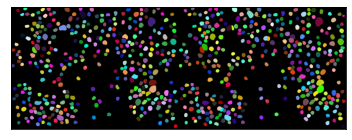

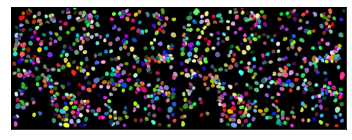

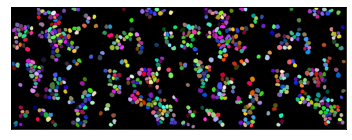

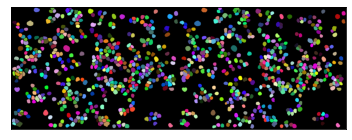

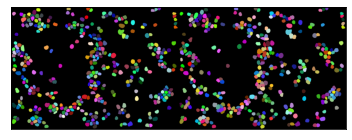

In [6]:
import matplotlib.pyplot as plt
for target, pred in zip(targets, predictions):
    plt.imshow(np.concatenate((eval.random_color(target), eval.random_color(pred)), axis=1))
    plt.xticks([]), plt.yticks([])
    plt.show()

In [13]:
import importlib
importlib.reload(eval)

rets = []
for target, pred in zip(targets, predictions):
    rets.extend(eval.compare_segmentations(target, pred))

100%|██████████| 358/358 [00:31<00:00, 11.35it/s]


In [20]:
import pandas as pd

df = pd.DataFrame(rets)
df.head()

d = []
    
for n in natsorted(df["mod"].unique()):
    tmp = df[df["mod"] == n]
    d.append({
        "mean": tmp.val.mean(),
        "std": tmp.val.std(),
        "measure": n,
        })

[{'mean': 0.914969650334272, 'std': 0.13418319933365982, 'measure': 'dice'},
 {'mean': 0.8607003625138944, 'std': 0.1435399984729482, 'measure': 'jaccard'},
 {'mean': 0.9279680200396149,
  'std': 0.12570761207706185,
  'measure': 'precision'},
 {'mean': 0.9113806416186377, 'std': 0.1505321759600596, 'measure': 'recall'}]

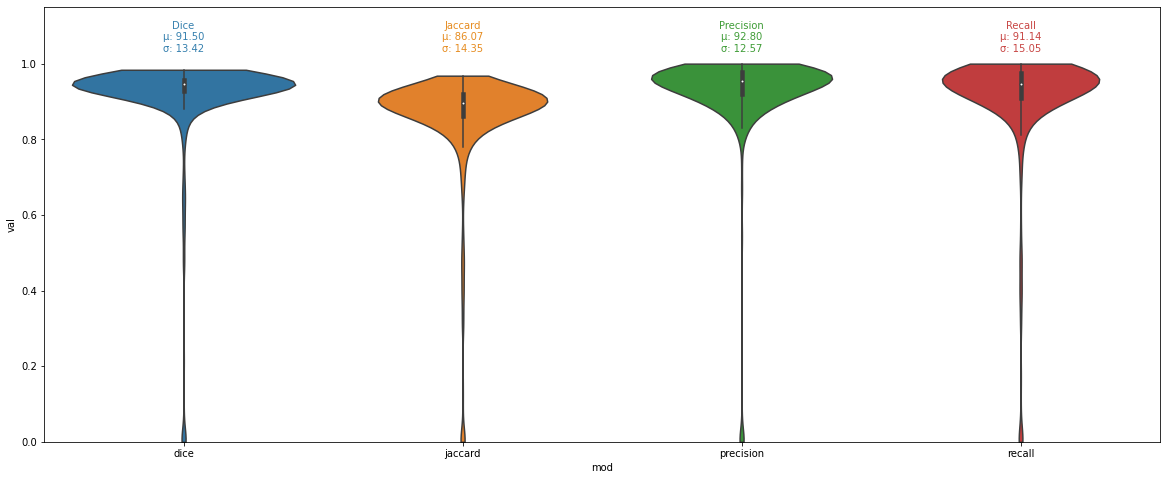

In [23]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = 20,8
ax = sb.violinplot(x="mod", y="val", data=df, cut=0)
ax.set_ylim(0, 1.15)

for info, n, c, val in zip(d, np.linspace(0,3,4), ["#3680AE", "#E68C20", "#3F9C37", "#C84644"], [f"Dice", f"Jaccard",f"Precision",f"Recall"]):
    plt.text(n, 1.07, f"{val}\nµ: {info['mean']*100:.2f}\nσ: {info['std']*100:.2f}", ha="center", va="center", c=c)

100%|██████████| 388/388 [00:30<00:00, 12.62it/s]


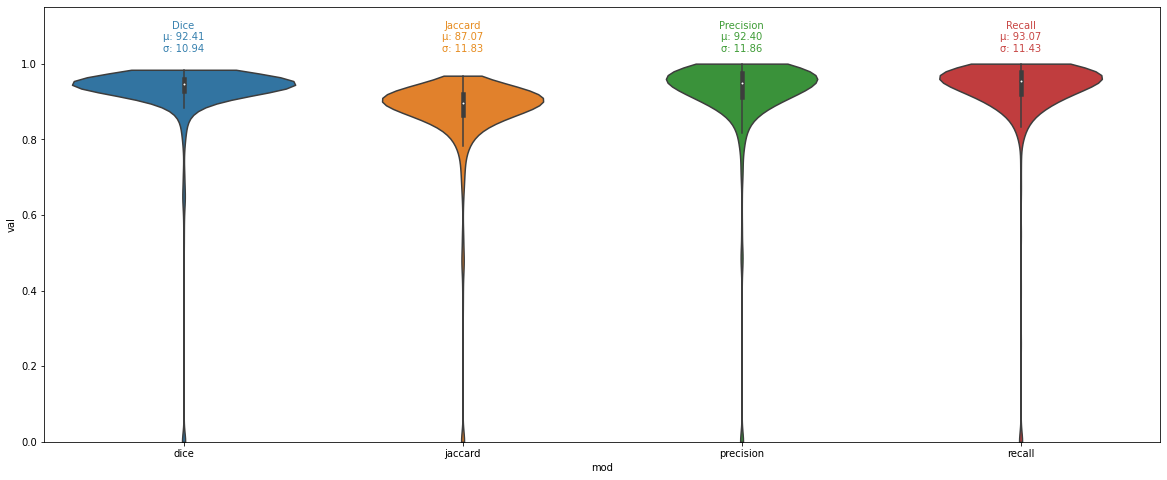

In [25]:
import importlib
importlib.reload(eval)

rets = []
for target, pred in zip(targets, predictions):
    rets.extend(eval.compare_segmentations(pred, target))
    
import pandas as pd

df = pd.DataFrame(rets)
df.head()

d = []
    
for n in natsorted(df["mod"].unique()):
    tmp = df[df["mod"] == n]
    d.append({
        "mean": tmp.val.mean(),
        "std": tmp.val.std(),
        "measure": n,
        })  
    
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = 20,8
ax = sb.violinplot(x="mod", y="val", data=df, cut=0)
ax.set_ylim(0, 1.15)

for info, n, c, val in zip(d, np.linspace(0,3,4), ["#3680AE", "#E68C20", "#3F9C37", "#C84644"], [f"Dice", f"Jaccard",f"Precision",f"Recall"]):
    plt.text(n, 1.07, f"{val}\nµ: {info['mean']*100:.2f}\nσ: {info['std']*100:.2f}", ha="center", va="center", c=c)